## CLUSTERING LONDON 

This is clustering on a ward level phase 1 using standardScaler as standardisation method for both of the models.

### DATA PROCESSING AND STANDARDIZATION

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score

from sklearn.decomposition import PCA

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
# CLEAN DATA FOR CLUSTERING
# Define the path to the CSV file
file_path = "/Users/alessandrosuarez_/Desktop/lastYRofUniShii/IndividualProjectIN3007/Deliverables/Workspace/data/processed/clean_final_data.csv"
# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)
# Display the first few rows of the DataFrame to verify its content
df.head(2)

,District,Lower layer super output area,Ward,Postcode,Postcode district,London zone,Latitude,Longitude,Average Income,Total Crimes,Index of Multiple Deprivation,Rural/urban,Average Rent Price,Budget-Friendly Rent Price,Median,Premium Rents Price,Mean average price,Annual mean average flat price,Annual mean average terraced price,Annual mean average semi price,Annual mean average detached price,"Agriculture, Forestry & Fishing",Manufacturing & Production,Building & Construction,Automotive Services,Grocery stores & Wholesale,Shops & Retail,Transportation & Storage,Hotels & Restaurants,Tech & Communication,Finance & Insurance,Real Estate Services,"Professional, Scientific & Technical",Business Administration & Support Services,Public Sector & Defence,Education,Healthcare Services,"Arts, Entertainment, Recreation & Other Services",Total parks in District,Majority_Christian,Majority_Hindu,Majority_Jewish,Majority_Muslim (Islam),Majority_No religion,Majority_Religion not stated,Majority_Sikh,Second_Christian,Second_Hindu,Second_Jewish,Second_Muslim (Islam),Second_No religion,Second_Religion not stated,Second_Sikh,Third_Christian,Third_Hindu,Third_Jewish,Third_Muslim (Islam),Third_No religion,Third_Other religion,Third_Religion not stated,Third_Sikh,Majority_African,Majority_Any other ethnic group,Majority_Arab,Majority_Australian/New Zealander,"Majority_Bangladeshi, British Bangladeshi",Majority_Caribbean,Majority_Chinese,Majority_Greek,Majority_Indian or British Indian,Majority_Irish,Majority_Korean,Majority_Other Western European,Majority_Pakistani or British Pakistani,Majority_Sri Lankan,Majority_Turkish,Majority_White and Asian,Second_Afghan,Second_African,Second_Any other ethnic group,Second_Arab,Second_Australian/New Zealander,"Second_Bangladeshi, British Bangladeshi",Second_Black British,Second_Caribbean,Second_Chinese,Second_English/Welsh/Scottish/Northern Irish/British,Second_European Mixed,Second_Filipino,Second_Greek,Second_Greek Cypriot,Second_Indian or British Indian,Second_Irish,Second_Japanese,Second_Korean,Second_North American,Second_Other Western European,Second_Pakistani or British Pakistani,Second_Sri Lankan,Second_Turkish,Second_White and Black Caribbean,Third_African,Third_Any other ethnic group,Third_Arab,Third_Australian/New Zealander,"Third_Bangladeshi, British Bangladeshi",Third_Black British,Third_Caribbean,Third_Chinese,Third_English/Welsh/Scottish/Northern Irish/British,Third_European Mixed,Third_Greek,Third_Greek Cypriot,Third_Indian or British Indian,Third_Irish,Third_Japanese,Third_Korean,Third_North American,Third_Other Western European,Third_Pakistani or British Pakistani,Third_Polish,Third_Sri Lankan,Third_Turkish,Third_White and Asian,Third_White and Black Caribbean
0,Barking and Dagenham,Barking and Dagenham 001A,Chadwell Heath,RM6 5PU,RM6,5,51.587985,0.134785,43600,334,5097,Urban major conurbation,1226.333333,1095.833333,1202.833333,1376.666667,355457.75,359436.75,235446.5,393380.0,444454.25,15.0,325.0,1965.0,270.0,385.0,775.0,760.0,380.0,465.0,60.0,175.0,725.0,770.0,0.0,130.0,340.0,345.0,73,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Barking and Dagenham,Barking and Dagenham 001A,Chadwell Heath,RM6 5LJ,RM6,5,51.584118,0.137387,43600,334,5097,Urban major conurbation,1226.333333,1095.833333,1202.833333,1376.666667,355457.75,359436.75,235446.5,393380.0,444454.25,15.0,325.0,1965.0,270.0,385.0,775.0,760.0,380.0,465.0,60.0,175.0,725.0,770.0,0.0,130.0,340.0,345.0,73,True,False,False,False,False,False,False,False,False,False,False,True,False,F

In [4]:
# Create a subset by dropping specific columns
columns_to_drop = [   
    "Lower layer super output area",      
    "Postcode",       
    "London zone",    
    "Latitude",    
    "Longitude",
    "Rural/urban"
]

# Drop the specified columns
df_ward = df.drop(columns=columns_to_drop)

# Group by the 'Ward' column and aggregate the 'Average Income' and 'Index of Multiple Deprivation' by their mean
df_grouped = df_ward.groupby('Ward').agg({
    'Average Income': 'mean',
    'Index of Multiple Deprivation': 'mean',
}).reset_index()

# Now df_grouped is indexed by Ward with each row representing aggregated data for that ward
df_ward = pd.merge(df_ward.drop(['Average Income', 'Index of Multiple Deprivation'], axis=1).drop_duplicates(subset=['Ward']), 
                    df_grouped, 
                    on='Ward', 
                    how='left')

# Reorder columns to place the aggregated 'Average Income' and 'Index of Multiple Deprivation' after 'Postcode district'
col_order = df_ward.columns.tolist()
insert_after_idx = col_order.index('Postcode district') + 1
new_order = col_order[:insert_after_idx] + ['Average Income', 'Index of Multiple Deprivation'] + col_order[insert_after_idx:-2]

# Subset to reorder
df_ward = df_ward[new_order]

# Reset the index
df_ward.reset_index(drop=True, inplace=True)

# Verify the changes
df_ward.head()


,District,Ward,Postcode district,Average Income,Index of Multiple Deprivation,Total Crimes,Average Rent Price,Budget-Friendly Rent Price,Median,Premium Rents Price,Mean average price,Annual mean average flat price,Annual mean average terraced price,Annual mean average semi price,Annual mean average detached price,"Agriculture, Forestry & Fishing",Manufacturing & Production,Building & Construction,Automotive Services,Grocery stores & Wholesale,Shops & Retail,Transportation & Storage,Hotels & Restaurants,Tech & Communication,Finance & Insurance,Real Estate Services,"Professional, Scientific & Technical",Business Administration & Support Services,Public Sector & Defence,Education,Healthcare Services,"Arts, Entertainment, Recreation & Other Services",Total parks in District,Majority_Christian,Majority_Hindu,Majority_Jewish,Majority_Muslim (Islam),Majority_No religion,Majority_Religion not stated,Majority_Sikh,Second_Christian,Second_Hindu,Second_Jewish,Second_Muslim (Islam),Second_No religion,Second_Religion not stated,Second_Sikh,Third_Christian,Third_Hindu,Third_Jewish,Third_Muslim (Islam),Third_No religion,Third_Other religion,Third_Religion not stated,Third_Sikh,Majority_African,Majority_Any other ethnic group,Majority_Arab,Majority_Australian/New Zealander,"Majority_Bangladeshi, British Bangladeshi",Majority_Caribbean,Majority_Chinese,Majority_Greek,Majority_Indian or British Indian,Majority_Irish,Majority_Korean,Majority_Other Western European,Majority_Pakistani or British Pakistani,Majority_Sri Lankan,Majority_Turkish,Majority_White and Asian,Second_Afghan,Second_African,Second_Any other ethnic group,Second_Arab,Second_Australian/New Zealander,"Second_Bangladeshi, British Bangladeshi",Second_Black British,Second_Caribbean,Second_Chinese,Second_English/Welsh/Scottish/Northern Irish/British,Second_European Mixed,Second_Filipino,Second_Greek,Second_Greek Cypriot,Second_Indian or British Indian,Second_Irish,Second_Japanese,Second_Korean,Second_North American,Second_Other Western European,Second_Pakistani or British Pakistani,Second_Sri Lankan,Second_Turkish,Second_White and Black Caribbean,Third_African,Third_Any other ethnic group,Third_Arab,Third_Australian/New Zealander,"Third_Bangladeshi, British Bangladeshi",Third_Black British,Third_Caribbean,Third_Chinese,Third_English/Welsh/Scottish/Northern Irish/British,Third_European Mixed,Third_Greek,Third_Greek Cypriot,Third_Indian or British Indian,Third_Irish,Third_Japanese,Third_Korean,Third_North American,Third_Other Western European,Third_Pakistani or British Pakistani,Third_Polish,Third_Sri Lankan,Third_Turkish,Third_White and Asian,Third_White and Black Caribbean
0,Barking and Dagenham,Chadwell Heath,RM6,46876.097561,8476.482927,334,1226.333333,1095.833333,1202.833333,1376.666667,355457.75,359436.75,235446.5,393380.0,444454.25,15.0,325.0,1965.0,270.0,385.0,775.0,760.0,380.0,465.0,60.0,175.0,725.0,770.0,0.0,130.0,340.0,345.0,73,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Barking and Dagenham,Whalebone,RM6,49055.974843,10235.981132,130,1226.333333,1095.833333,1202.833333,1376.666667,355457.75,359436.75,235446.5,393380.0,444454.25,15.0,325.0,1965.0,270.0,385.0,775.0,760.0,380.0,465.0,60.0,175.0,725.0,770.0,0.0,130.0,340.0,345.0,73,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,Fals

In [5]:
# Verify the shape
df_ward.shape

(667, 119)

In [6]:
# Create a subset by dropping specific columns
columns_to_drop = [ 
    "District",
    "Ward",
    "Postcode district"
]

# Dropping the specified columns
dfSubset = df_ward.drop(columns=columns_to_drop)

# Displaying the first few rows of the subset DataFrame to verify its content
dfSubset.head()

,Average Income,Index of Multiple Deprivation,Total Crimes,Average Rent Price,Budget-Friendly Rent Price,Median,Premium Rents Price,Mean average price,Annual mean average flat price,Annual mean average terraced price,Annual mean average semi price,Annual mean average detached price,"Agriculture, Forestry & Fishing",Manufacturing & Production,Building & Construction,Automotive Services,Grocery stores & Wholesale,Shops & Retail,Transportation & Storage,Hotels & Restaurants,Tech & Communication,Finance & Insurance,Real Estate Services,"Professional, Scientific & Technical",Business Administration & Support Services,Public Sector & Defence,Education,Healthcare Services,"Arts, Entertainment, Recreation & Other Services",Total parks in District,Majority_Christian,Majority_Hindu,Majority_Jewish,Majority_Muslim (Islam),Majority_No religion,Majority_Religion not stated,Majority_Sikh,Second_Christian,Second_Hindu,Second_Jewish,Second_Muslim (Islam),Second_No religion,Second_Religion not stated,Second_Sikh,Third_Christian,Third_Hindu,Third_Jewish,Third_Muslim (Islam),Third_No religion,Third_Other religion,Third_Religion not stated,Third_Sikh,Majority_African,Majority_Any other ethnic group,Majority_Arab,Majority_Australian/New Zealander,"Majority_Bangladeshi, British Bangladeshi",Majority_Caribbean,Majority_Chinese,Majority_Greek,Majority_Indian or British Indian,Majority_Irish,Majority_Korean,Majority_Other Western European,Majority_Pakistani or British Pakistani,Majority_Sri Lankan,Majority_Turkish,Majority_White and Asian,Second_Afghan,Second_African,Second_Any other ethnic group,Second_Arab,Second_Australian/New Zealander,"Second_Bangladeshi, British Bangladeshi",Second_Black British,Second_Caribbean,Second_Chinese,Second_English/Welsh/Scottish/Northern Irish/British,Second_European Mixed,Second_Filipino,Second_Greek,Second_Greek Cypriot,Second_Indian or British Indian,Second_Irish,Second_Japanese,Second_Korean,Second_North American,Second_Other Western European,Second_Pakistani or British Pakistani,Second_Sri Lankan,Second_Turkish,Second_White and Black Caribbean,Third_African,Third_Any other ethnic group,Third_Arab,Third_Australian/New Zealander,"Third_Bangladeshi, British Bangladeshi",Third_Black British,Third_Caribbean,Third_Chinese,Third_English/Welsh/Scottish/Northern Irish/British,Third_European Mixed,Third_Greek,Third_Greek Cypriot,Third_Indian or British Indian,Third_Irish,Third_Japanese,Third_Korean,Third_North American,Third_Other Western European,Third_Pakistani or British Pakistani,Third_Polish,Third_Sri Lankan,Third_Turkish,Third_White and Asian,Third_White and Black Caribbean
0,46876.097561,8476.482927,334,1226.333333,1095.833333,1202.833333,1376.666667,355457.75,359436.75,235446.5,393380.0,444454.25,15.0,325.0,1965.0,270.0,385.0,775.0,760.0,380.0,465.0,60.0,175.0,725.0,770.0,0.0,130.0,340.0,345.0,73,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,49055.974843,10235.981132,130,1226.333333,1095.833333,1202.833333,1376.666667,355457.75,359436.75,235446.5,393380.0,444454.25,15.0,325.0,1965.0,270.0,385.0,775.0,760.0,380.0,465.0,60.0,175.0,725.0,770.0,0.0,130.0,340.0,345.0,73,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Fals

In [7]:
# Checking data types to convert to numerical values
dfSubset.dtypes

Average Income                                          float64
Index of Multiple Deprivation                           float64
Total Crimes                                              int64
Average Rent Price                                      float64
Budget-Friendly Rent Price                              float64
Median                                                  float64
Premium Rents Price                                     float64
Mean average price                                      float64
Annual mean average flat price                          float64
Annual mean average terraced price                      float64
Annual mean average semi price                          float64
Annual mean average detached price                      float64
Agriculture, Forestry & Fishing                         float64
Manufacturing & Production                              float64
Building & Construction                                 float64
Automotive Services                     

In [8]:
# List of boolean columns
bool_columns = [
    "Majority_Christian", "Majority_Hindu", "Majority_Jewish", "Majority_Muslim (Islam)",
    "Majority_No religion", "Majority_Religion not stated", "Majority_Sikh", "Second_Christian",
    "Second_Hindu", "Second_Jewish", "Second_Muslim (Islam)", "Second_No religion",
    "Second_Religion not stated", "Second_Sikh", "Third_Christian", "Third_Hindu",
    "Third_Jewish", "Third_Muslim (Islam)", "Third_No religion", "Third_Other religion",
    "Third_Religion not stated", "Third_Sikh", "Majority_African", "Majority_Any other ethnic group",
    "Majority_Arab", "Majority_Australian/New Zealander", "Majority_Bangladeshi, British Bangladeshi",
    "Majority_Caribbean", "Majority_Chinese", "Majority_Greek", "Majority_Indian or British Indian",
    "Majority_Irish", "Majority_Korean", "Majority_Other Western European", "Majority_Pakistani or British Pakistani",
    "Majority_Sri Lankan", "Majority_Turkish", "Majority_White and Asian", "Second_Afghan",
    "Second_African", "Second_Any other ethnic group", "Second_Arab", "Second_Australian/New Zealander",
    "Second_Bangladeshi, British Bangladeshi", "Second_Black British", "Second_Caribbean",
    "Second_Chinese", "Second_English/Welsh/Scottish/Northern Irish/British", "Second_European Mixed",
    "Second_Filipino", "Second_Greek", "Second_Greek Cypriot", "Second_Indian or British Indian",
    "Second_Irish", "Second_Japanese", "Second_Korean", "Second_North American", "Second_Other Western European",
    "Second_Pakistani or British Pakistani", "Second_Sri Lankan", "Second_Turkish", "Second_White and Black Caribbean",
    "Third_African", "Third_Any other ethnic group", "Third_Arab", "Third_Australian/New Zealander",
    "Third_Bangladeshi, British Bangladeshi", "Third_Black British", "Third_Caribbean", "Third_Chinese",
    "Third_English/Welsh/Scottish/Northern Irish/British", "Third_European Mixed", "Third_Greek",
    "Third_Greek Cypriot", "Third_Indian or British Indian", "Third_Irish", "Third_Japanese",
    "Third_Korean", "Third_North American", "Third_Other Western European", "Third_Pakistani or British Pakistani",
    "Third_Polish", "Third_Sri Lankan", "Third_Turkish", "Third_White and Asian", "Third_White and Black Caribbean"
]

# Convert boolean columns to int
for column in bool_columns:
    dfSubset[column] = dfSubset[column].astype(int)

dfSubset.dtypes


Average Income                                          float64
Index of Multiple Deprivation                           float64
Total Crimes                                              int64
Average Rent Price                                      float64
Budget-Friendly Rent Price                              float64
Median                                                  float64
Premium Rents Price                                     float64
Mean average price                                      float64
Annual mean average flat price                          float64
Annual mean average terraced price                      float64
Annual mean average semi price                          float64
Annual mean average detached price                      float64
Agriculture, Forestry & Fishing                         float64
Manufacturing & Production                              float64
Building & Construction                                 float64
Automotive Services                     

In [9]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the entire dfSubset (as all features are now numerical)
dfSubset_scaled = scaler.fit_transform(dfSubset)

# Convert the scaled array back to a DataFrame, using the same column names
dfSubset_scaled_df = pd.DataFrame(dfSubset_scaled, columns=dfSubset.columns)

# This is the final scaled DataFrame ready for clustering
dfSubset_final = dfSubset_scaled_df

# Display the first few rows to verify the scaled data
dfSubset_final.head()

,Average Income,Index of Multiple Deprivation,Total Crimes,Average Rent Price,Budget-Friendly Rent Price,Median,Premium Rents Price,Mean average price,Annual mean average flat price,Annual mean average terraced price,Annual mean average semi price,Annual mean average detached price,"Agriculture, Forestry & Fishing",Manufacturing & Production,Building & Construction,Automotive Services,Grocery stores & Wholesale,Shops & Retail,Transportation & Storage,Hotels & Restaurants,Tech & Communication,Finance & Insurance,Real Estate Services,"Professional, Scientific & Technical",Business Administration & Support Services,Public Sector & Defence,Education,Healthcare Services,"Arts, Entertainment, Recreation & Other Services",Total parks in District,Majority_Christian,Majority_Hindu,Majority_Jewish,Majority_Muslim (Islam),Majority_No religion,Majority_Religion not stated,Majority_Sikh,Second_Christian,Second_Hindu,Second_Jewish,Second_Muslim (Islam),Second_No religion,Second_Religion not stated,Second_Sikh,Third_Christian,Third_Hindu,Third_Jewish,Third_Muslim (Islam),Third_No religion,Third_Other religion,Third_Religion not stated,Third_Sikh,Majority_African,Majority_Any other ethnic group,Majority_Arab,Majority_Australian/New Zealander,"Majority_Bangladeshi, British Bangladeshi",Majority_Caribbean,Majority_Chinese,Majority_Greek,Majority_Indian or British Indian,Majority_Irish,Majority_Korean,Majority_Other Western European,Majority_Pakistani or British Pakistani,Majority_Sri Lankan,Majority_Turkish,Majority_White and Asian,Second_Afghan,Second_African,Second_Any other ethnic group,Second_Arab,Second_Australian/New Zealander,"Second_Bangladeshi, British Bangladeshi",Second_Black British,Second_Caribbean,Second_Chinese,Second_English/Welsh/Scottish/Northern Irish/British,Second_European Mixed,Second_Filipino,Second_Greek,Second_Greek Cypriot,Second_Indian or British Indian,Second_Irish,Second_Japanese,Second_Korean,Second_North American,Second_Other Western European,Second_Pakistani or British Pakistani,Second_Sri Lankan,Second_Turkish,Second_White and Black Caribbean,Third_African,Third_Any other ethnic group,Third_Arab,Third_Australian/New Zealander,"Third_Bangladeshi, British Bangladeshi",Third_Black British,Third_Caribbean,Third_Chinese,Third_English/Welsh/Scottish/Northern Irish/British,Third_European Mixed,Third_Greek,Third_Greek Cypriot,Third_Indian or British Indian,Third_Irish,Third_Japanese,Third_Korean,Third_North American,Third_Other Western European,Third_Pakistani or British Pakistani,Third_Polish,Third_Sri Lankan,Third_Turkish,Third_White and Asian,Third_White and Black Caribbean
0,-1.222475,-0.974674,-0.011202,-1.080588,-1.060132,-1.071065,-1.010352,-0.906563,-0.809819,-0.695933,-0.588106,-0.511518,-0.581197,-0.843393,0.075907,0.341102,-0.786287,-0.95945,0.934117,-1.18692,-1.131235,-0.427094,-0.781302,-1.044978,-0.829439,-0.450935,-1.42555,-1.17107,-1.088403,-0.969846,0.624166,-0.135354,-0.095274,-0.27533,-0.463612,0.0,-0.077674,-0.29078,-0.235329,-0.11018,-0.517746,0.943143,-0.355934,-0.067217,-0.116952,-0.287736,-0.116952,-0.607955,-0.451632,0.0,1.150670,-0.166538,-0.161722,-0.054841,0.0,0.0,-0.054841,2.124240,-0.038749,0.0,-0.224485,-1.578653,-0.038749,-0.129492,-0.067217,0.0,-0.038749,0.0,0.0,1.872634,-0.095274,0.0,-0.038749,-0.140988,-0.054841,-0.415008,-0.067217,-0.98956,0.0,0.0,0.0,0.0,-0.23176,-0.180299,0.0,0.0,-0.054841,-0.102986,-0.038749,-0.038749,0.0,0.0,-0.517746,-0.166538,-0.067217,-0.077674,-0.102986,2.453783,-0.682594,-0.077674,-0.25592,-0.054841,-0.123372,0.0,-0.325785,-0.161722,0.0,-0.038749,0.0,-0.205396,-0.140988,-0.067217,-0.054841,-0.038749,0.0,-0.054841
1,-0.997229,-0.713376,-0.508826,-1.080588,-1.060132,-1.071065,-1.010352,-0.906563,-0.809819,-0.695933,-0.588106,-0.511518,-0.581197,-0.843393,0.075907,0.341102,-0.786287,-0.95945,0.934117,-1.18692,-1.131235,-0.427094,-0.781302,-1.044978,-0.829439,-0.450935,-1.42555,-1.17107,-1.088403,-0.969846,0.624166,-0.135354,-0.095274,-0.27533,-0.463612,0.0,-0.07

In [10]:
# Checking the df shape
dfSubset_final.shape

(667, 116)

In [11]:
# Double checking the features are ready for clustering
dfSubset_final.dtypes

Average Income                                          float64
Index of Multiple Deprivation                           float64
Total Crimes                                            float64
Average Rent Price                                      float64
Budget-Friendly Rent Price                              float64
Median                                                  float64
Premium Rents Price                                     float64
Mean average price                                      float64
Annual mean average flat price                          float64
Annual mean average terraced price                      float64
Annual mean average semi price                          float64
Annual mean average detached price                      float64
Agriculture, Forestry & Fishing                         float64
Manufacturing & Production                              float64
Building & Construction                                 float64
Automotive Services                     

### KMEANS

/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

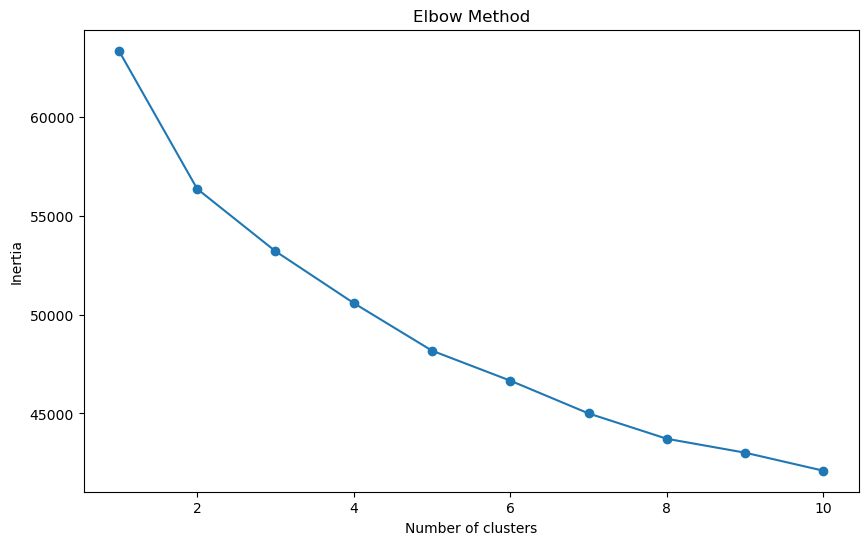

In [12]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dfSubset_final) # dfSubset_final
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

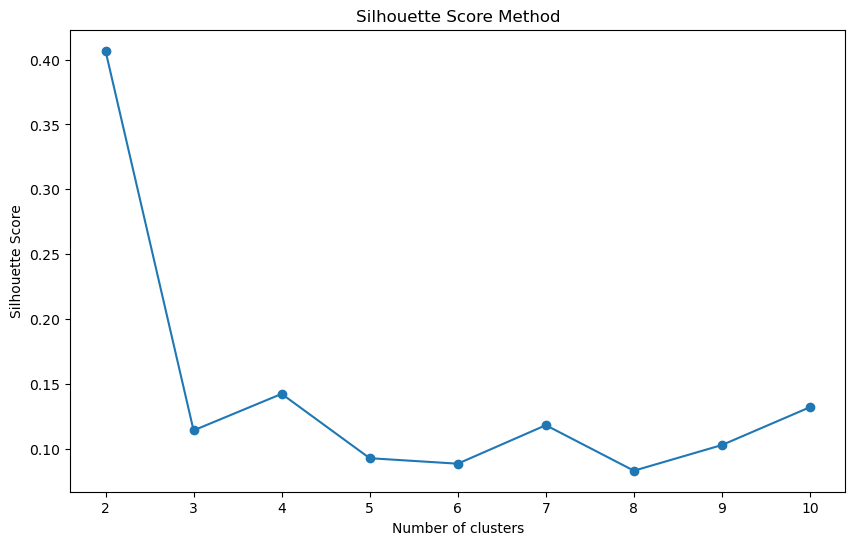

In [13]:
# Silhouette Score
silhouette_scores = []
for k in range(2, 11):  # Silhouette score can't be computed for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dfSubset_final) # dfSubset_final
    cluster_labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(dfSubset_final, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

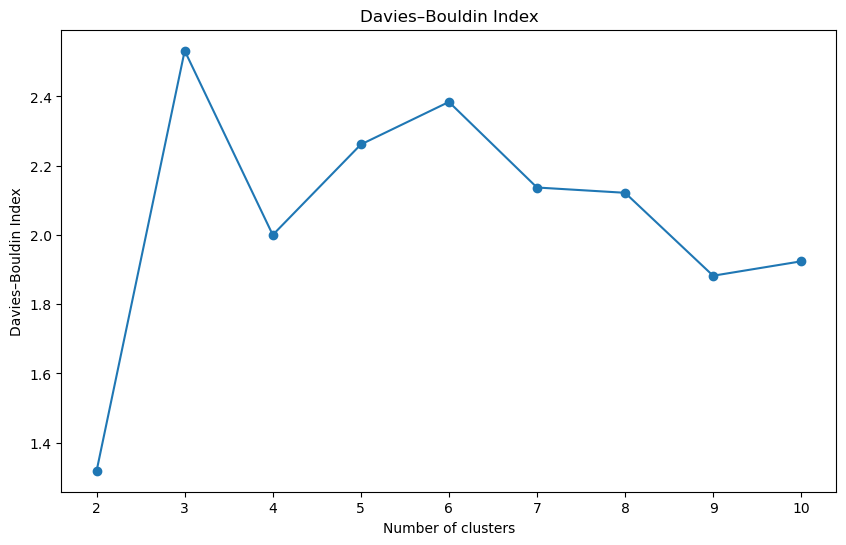

In [14]:
# David-Bouildin Index
db_scores = []
for k in range(2, 11):  # Can't compute for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dfSubset_final) # dfSubset_final
    cluster_labels = kmeans.labels_
    db_scores.append(davies_bouldin_score(dfSubset_final, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_scores, marker='o')
plt.title('Davies–Bouldin Index')
plt.xlabel('Number of clusters')
plt.ylabel('Davies–Bouldin Index')
plt.show()


In [15]:
# Initialize KMeans with k clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the model data
kmeans.fit(dfSubset_final)  # dfSubset_final is the scaled dataset after standardization

# The labels_ attribute give the assigned cluster labels
cluster_labels = kmeans.labels_

# The cluster labels is a new column to DataFrame 
df_ward['Cluster_Labels'] = cluster_labels

# To see the first few entries with their respective cluster assignments
df_ward.head()


/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,District,Ward,Postcode district,Average Income,Index of Multiple Deprivation,Total Crimes,Average Rent Price,Budget-Friendly Rent Price,Median,Premium Rents Price,Mean average price,Annual mean average flat price,Annual mean average terraced price,Annual mean average semi price,Annual mean average detached price,"Agriculture, Forestry & Fishing",Manufacturing & Production,Building & Construction,Automotive Services,Grocery stores & Wholesale,Shops & Retail,Transportation & Storage,Hotels & Restaurants,Tech & Communication,Finance & Insurance,Real Estate Services,"Professional, Scientific & Technical",Business Administration & Support Services,Public Sector & Defence,Education,Healthcare Services,"Arts, Entertainment, Recreation & Other Services",Total parks in District,Majority_Christian,Majority_Hindu,Majority_Jewish,Majority_Muslim (Islam),Majority_No religion,Majority_Religion not stated,Majority_Sikh,Second_Christian,Second_Hindu,Second_Jewish,Second_Muslim (Islam),Second_No religion,Second_Religion not stated,Second_Sikh,Third_Christian,Third_Hindu,Third_Jewish,Third_Muslim (Islam),Third_No religion,Third_Other religion,Third_Religion not stated,Third_Sikh,Majority_African,Majority_Any other ethnic group,Majority_Arab,Majority_Australian/New Zealander,"Majority_Bangladeshi, British Bangladeshi",Majority_Caribbean,Majority_Chinese,Majority_Greek,Majority_Indian or British Indian,Majority_Irish,Majority_Korean,Majority_Other Western European,Majority_Pakistani or British Pakistani,Majority_Sri Lankan,Majority_Turkish,Majority_White and Asian,Second_Afghan,Second_African,Second_Any other ethnic group,Second_Arab,Second_Australian/New Zealander,"Second_Bangladeshi, British Bangladeshi",Second_Black British,Second_Caribbean,Second_Chinese,Second_English/Welsh/Scottish/Northern Irish/British,Second_European Mixed,Second_Filipino,Second_Greek,Second_Greek Cypriot,Second_Indian or British Indian,Second_Irish,Second_Japanese,Second_Korean,Second_North American,Second_Other Western European,Second_Pakistani or British Pakistani,Second_Sri Lankan,Second_Turkish,Second_White and Black Caribbean,Third_African,Third_Any other ethnic group,Third_Arab,Third_Australian/New Zealander,"Third_Bangladeshi, British Bangladeshi",Third_Black British,Third_Caribbean,Third_Chinese,Third_English/Welsh/Scottish/Northern Irish/British,Third_European Mixed,Third_Greek,Third_Greek Cypriot,Third_Indian or British Indian,Third_Irish,Third_Japanese,Third_Korean,Third_North American,Third_Other Western European,Third_Pakistani or British Pakistani,Third_Polish,Third_Sri Lankan,Third_Turkish,Third_White and Asian,Third_White and Black Caribbean,Cluster_Labels
0,Barking and Dagenham,Chadwell Heath,RM6,46876.097561,8476.482927,334,1226.333333,1095.833333,1202.833333,1376.666667,355457.75,359436.75,235446.5,393380.0,444454.25,15.0,325.0,1965.0,270.0,385.0,775.0,760.0,380.0,465.0,60.0,175.0,725.0,770.0,0.0,130.0,340.0,345.0,73,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4
1,Barking and Dagenham,Whalebone,RM6,49055.974843,10235.981132,130,1226.333333,1095.833333,1202.833333,1376.666667,355457.75,359436.75,235446.5,393380.0,444454.25,15.0,325.0,1965.0,270.0,385.0,775.0,760.0,380.0,465.0,60.0,175.0,725.0,770.0,0.0,130.0,340.0,345.0,73,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alessandrosuarez_/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


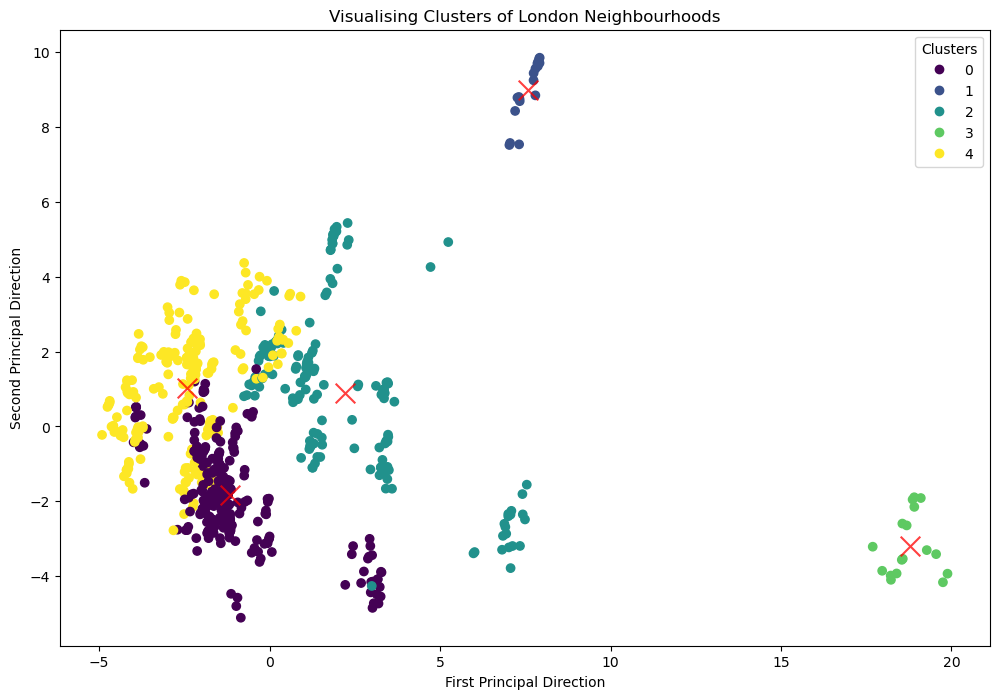

In [16]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(dfSubset_final)
labels = kmeans.labels_

# Further reduce the dimensionality to 2 components for visualization
pca_for_visualization = PCA(n_components=2)
dfSubset_visualization = pca_for_visualization.fit_transform(dfSubset_final)

# Plotting the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(dfSubset_visualization[:, 0], dfSubset_visualization[:, 1], c=labels, cmap='viridis', marker='o')

# Plot the centroids from dfSubset_visualization
centroids = kmeans.cluster_centers_
centroids_visualization = pca_for_visualization.transform(centroids)
plt.scatter(centroids_visualization[:, 0], centroids_visualization[:, 1], c='red', s=200, alpha=0.75, marker='x')

# Adding titles and labels
plt.title('Visualising Clusters of London Neighbourhoods')
plt.xlabel('First Principal Direction')
plt.ylabel('Second Principal Direction')

# Adding legend for cluster labels
plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()


The average silhouette_score is : 0.09275312977946186


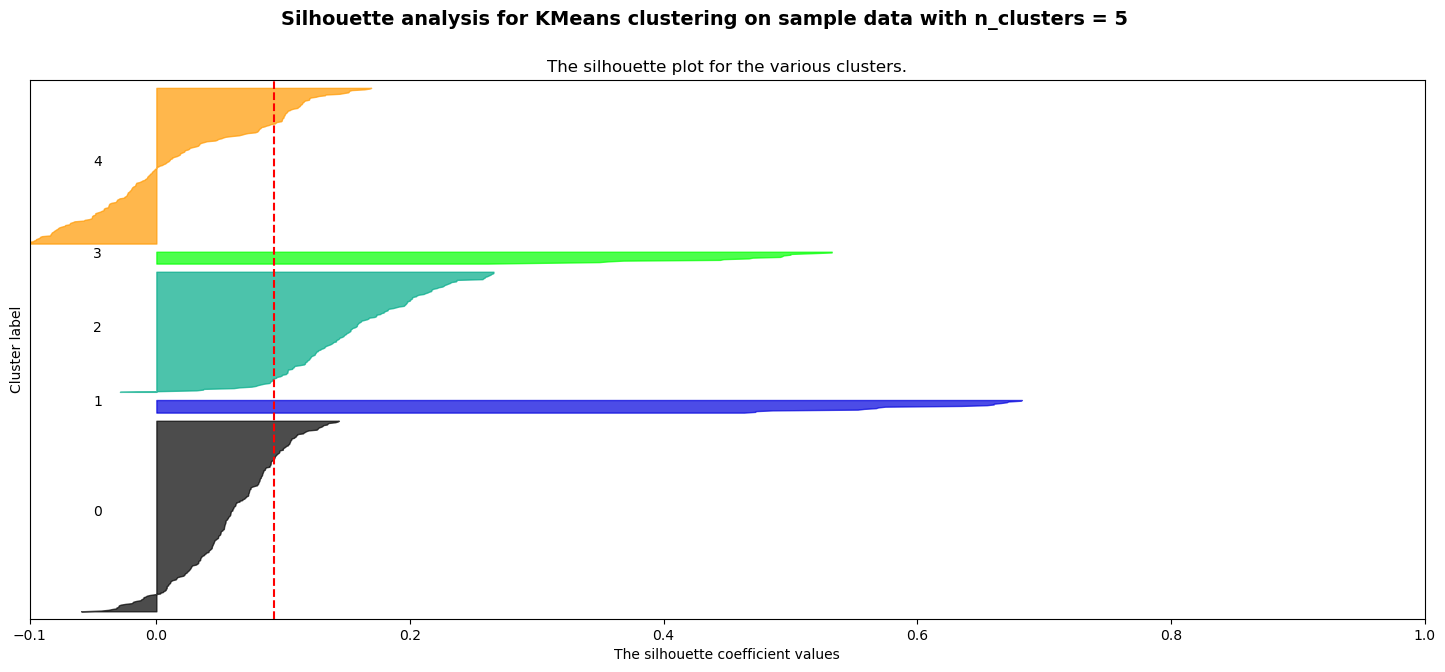

In [17]:
# Silhouette average score and plot
silhouette_avg = silhouette_score(dfSubset_final, cluster_labels)
print(f"The average silhouette_score is : {silhouette_avg}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(dfSubset_final, cluster_labels)

# Create a subplot with 1 row and 1 column
fig, ax1 = plt.subplots(1)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(dfSubset_final) + (kmeans.n_clusters + 1) * 10])

y_lower = 10
for i in range(kmeans.n_clusters):  
     # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / kmeans.n_clusters)  
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label for the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              f"with n_clusters = {kmeans.n_clusters}"),
             fontsize=14, fontweight='bold')

plt.show()


### DBSCAN

In [18]:
# Initialize DBSCAN with eps and min_samples parameters
# Starting point (eps=0.9, min_samples=5) it did not perform well
dbscan = DBSCAN(eps=4, min_samples=5) # The best cluster with these parameters

# Fit the model data
dbscan.fit(dfSubset_final)

# The labels_ attribute provide the assigned cluster labels
dbscan_labels = dbscan.labels_

# DBSCAN cluster labels as a new column in the DataFrame
df_ward['DBSCAN_Cluster_Labels'] = dbscan_labels

# Check how many unique clusters were created
n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_ = list(dbscan_labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

# To see the first few entries with their respective cluster assignments
df_ward.head()

Estimated number of clusters: 18
Estimated number of noise points: 323


,District,Ward,Postcode district,Average Income,Index of Multiple Deprivation,Total Crimes,Average Rent Price,Budget-Friendly Rent Price,Median,Premium Rents Price,Mean average price,Annual mean average flat price,Annual mean average terraced price,Annual mean average semi price,Annual mean average detached price,"Agriculture, Forestry & Fishing",Manufacturing & Production,Building & Construction,Automotive Services,Grocery stores & Wholesale,Shops & Retail,Transportation & Storage,Hotels & Restaurants,Tech & Communication,Finance & Insurance,Real Estate Services,"Professional, Scientific & Technical",Business Administration & Support Services,Public Sector & Defence,Education,Healthcare Services,"Arts, Entertainment, Recreation & Other Services",Total parks in District,Majority_Christian,Majority_Hindu,Majority_Jewish,Majority_Muslim (Islam),Majority_No religion,Majority_Religion not stated,Majority_Sikh,Second_Christian,Second_Hindu,Second_Jewish,Second_Muslim (Islam),Second_No religion,Second_Religion not stated,Second_Sikh,Third_Christian,Third_Hindu,Third_Jewish,Third_Muslim (Islam),Third_No religion,Third_Other religion,Third_Religion not stated,Third_Sikh,Majority_African,Majority_Any other ethnic group,Majority_Arab,Majority_Australian/New Zealander,"Majority_Bangladeshi, British Bangladeshi",Majority_Caribbean,Majority_Chinese,Majority_Greek,Majority_Indian or British Indian,Majority_Irish,Majority_Korean,Majority_Other Western European,Majority_Pakistani or British Pakistani,Majority_Sri Lankan,Majority_Turkish,Majority_White and Asian,Second_Afghan,Second_African,Second_Any other ethnic group,Second_Arab,Second_Australian/New Zealander,"Second_Bangladeshi, British Bangladeshi",Second_Black British,Second_Caribbean,Second_Chinese,Second_English/Welsh/Scottish/Northern Irish/British,Second_European Mixed,Second_Filipino,Second_Greek,Second_Greek Cypriot,Second_Indian or British Indian,Second_Irish,Second_Japanese,Second_Korean,Second_North American,Second_Other Western European,Second_Pakistani or British Pakistani,Second_Sri Lankan,Second_Turkish,Second_White and Black Caribbean,Third_African,Third_Any other ethnic group,Third_Arab,Third_Australian/New Zealander,"Third_Bangladeshi, British Bangladeshi",Third_Black British,Third_Caribbean,Third_Chinese,Third_English/Welsh/Scottish/Northern Irish/British,Third_European Mixed,Third_Greek,Third_Greek Cypriot,Third_Indian or British Indian,Third_Irish,Third_Japanese,Third_Korean,Third_North American,Third_Other Western European,Third_Pakistani or British Pakistani,Third_Polish,Third_Sri Lankan,Third_Turkish,Third_White and Asian,Third_White and Black Caribbean,Cluster_Labels,DBSCAN_Cluster_Labels
0,Barking and Dagenham,Chadwell Heath,RM6,46876.097561,8476.482927,334,1226.333333,1095.833333,1202.833333,1376.666667,355457.75,359436.75,235446.5,393380.0,444454.25,15.0,325.0,1965.0,270.0,385.0,775.0,760.0,380.0,465.0,60.0,175.0,725.0,770.0,0.0,130.0,340.0,345.0,73,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4,0
1,Barking and Dagenham,Whalebone,RM6,49055.974843,10235.981132,130,1226.333333,1095.833333,1202.833333,1376.666667,355457.75,359436.75,235446.5,393380.0,444454.25,15.0,325.0,1965.0,270.0,385.0,775.0,760.0,380.0,465.0,60.0,175.0,725.0,770.0,0.0,130.0,340.0,345.0,73,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,Fals

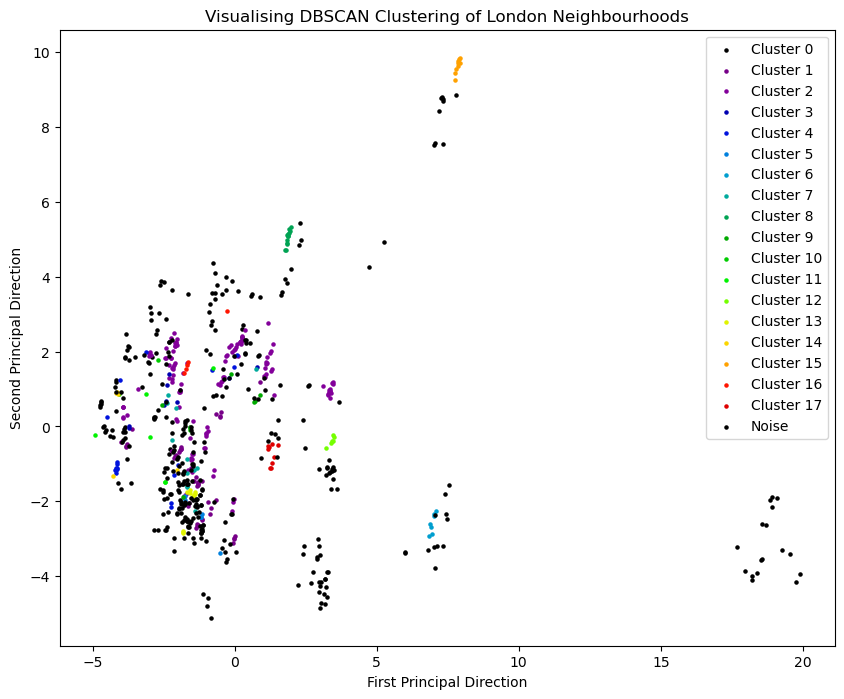

In [19]:
# DBSCAN Plot
# Initialise PCA to reduce the data to 2 components for visualisation
pca_2d = PCA(n_components=2)

# Fit and transform the data
reduced_data = pca_2d.fit_transform(dfSubset_final)
plt.figure(figsize=(10, 8))

# Plotting each cluster
unique_labels = set(dbscan_labels)
for label in unique_labels:
    # Selecting data points that belong to the current label
    points = reduced_data[dbscan_labels == label]
    
    # Noise points are labeled as -1
    if label == -1:
        color = 'k'  # black for noise
    else:
        color = plt.cm.nipy_spectral(float(label) / len(unique_labels))  
    
    # Plot points
    plt.scatter(points[:, 0], points[:, 1], s=5, color=color, label=f'Cluster {label}' if label != -1 else 'Noise')

# Adding titles and labels
plt.legend(loc='best')
plt.title('Visualising DBSCAN Clustering of London Neighbourhoods')
plt.xlabel('First Principal Direction')
plt.ylabel('Second Principal Direction')
plt.show()
